In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob, os

import scienceplots
plt.style.use(['science', 'notebook', 'grid'])

In [2]:
folder = "../build/"
all_files = glob.glob(os.path.join(folder, "particle*.csv"))
# sort files by modification time
all_files.sort(key=os.path.getmtime, reverse=True)
print(all_files)

['../build/particle_history_1761094556_particle_4.csv', '../build/particle_history_1761094556_particle_3.csv', '../build/particle_history_1761094556_particle_2.csv', '../build/particle_history_1761094556_particle_1.csv', '../build/particle_history_1761094556_particle_0.csv']


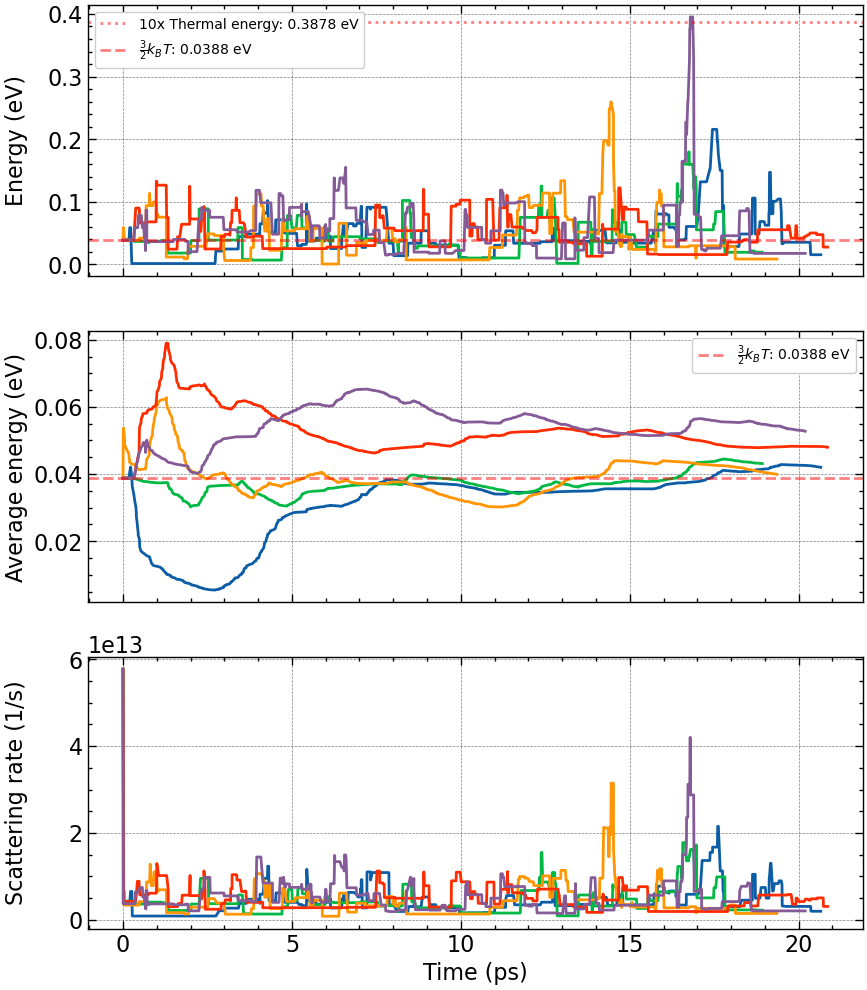

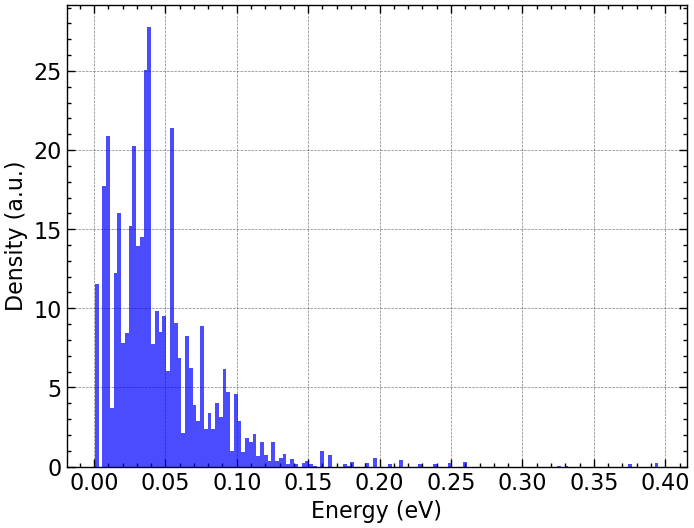

In [3]:
fig, ax = plt.subplots(3, sharex=True, figsize=(10, 12))
NbFilesToPlot = 5
all_energies = np.array([])
for file in all_files[:NbFilesToPlot]:
    data = np.loadtxt(file, delimiter=',', skiprows=1)
    nb_cols = data.shape[1]
    energy_data = data[:, nb_cols - 1]
    time = 1e12 * data[:, 0]
    ax[0].plot(time, energy_data)
    cum_mean = np.cumsum(energy_data) / np.arange(1, len(energy_data) + 1)
    ax[1].plot(time, cum_mean)
    gamma_data = data[:, 1]
    ax[2].plot(time, gamma_data)
    final_mean = cum_mean[-1]
    all_energies = np.concatenate((all_energies, energy_data), axis=0)

kB = 8.617333262145e-5  # eV/K
T = 300  # K
thermal_energy = (3.0/2.0) * kB * T
ax[0].axhline(10*thermal_energy, color='r', linestyle=':', label=f'10x Thermal energy: {10*thermal_energy:.4f} eV', alpha=0.5)
ax[0].axhline(thermal_energy, color='r', linestyle='--', label=f'$\\frac{{3}}{{2}} k_B T$: {thermal_energy:.4f} eV', alpha=0.5)
ax[1].axhline(thermal_energy, color='r', linestyle='--', label=f'$\\frac{{3}}{{2}} k_B T$: {thermal_energy:.4f} eV', alpha=0.5)
ax[0].legend(fontsize=10, loc='upper left')
ax[1].legend(fontsize=10, loc='upper right')
ax[0].set_ylabel("Energy (eV)")
ax[1].set_ylabel("Average energy (eV)")
ax[2].set_xlabel("Time (ps)")
ax[2].set_ylabel("Scattering rate (1/s)")
fig.align_ylabels()


fig, ax = plt.subplots(1, figsize=(8, 6))
ax.hist(all_energies, bins=150, density=True, alpha=0.7, color='b', label='Energy distribution')
ax.set_xlabel("Energy (eV)")
ax.set_ylabel("Density (a.u.)")
plt.show()

['../build/mesh2_T300K_C2V3_N399413_eph_rates.msh']


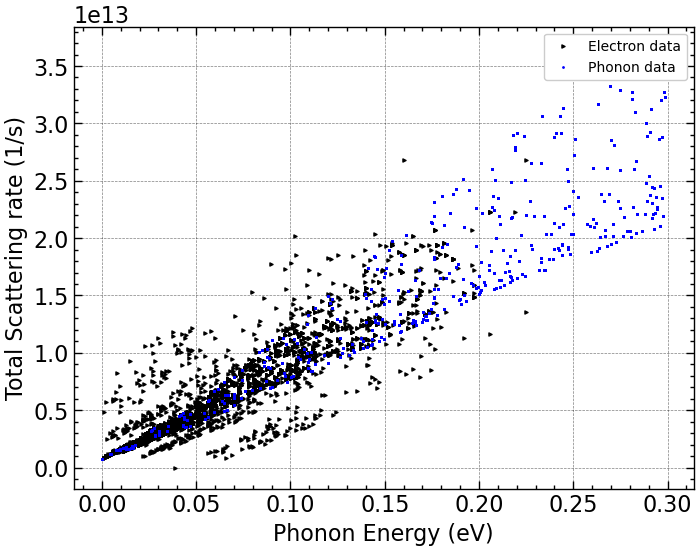

In [61]:
file_phononss = glob.glob(os.path.join(folder, "*eph*.msh"))
print(file_phononss)
data_phonons = np.loadtxt(file_phononss[0], delimiter=',', skiprows=1)
NbCols = data_phonons.shape[1]
# vtx, band, energy, rates...
energies_ph = data_phonons[:, 2]
total_rates_ph = np.sum(data_phonons[:, 3:NbCols], axis=1)
fig, ax = plt.subplots(1, figsize=(8, 6))
ax.scatter(energy_data, gamma_data, s=5, c='k',marker='>', label='Electron data')
ax.scatter(energies_ph, total_rates_ph, s=1, c='b', label='Phonon data')
# for idx in range(0, 8):
#     rates_ph = data_phonons[:, 3 + idx]
#     ax.scatter(energies_ph, rates_ph, s=1)
ax.set_xlabel("Phonon Energy (eV)")
ax.set_ylabel("Total Scattering rate (1/s)")
ax.legend(fontsize=10, loc='upper right')
plt.show()